In [568]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [569]:
df_100 = pd.read_csv('pre_fusion_data.csv')

In [570]:
df_100.index = df_100['Unnamed: 0']
df_100.rename_axis('timestamp', inplace=True)
df_100.drop(['Unnamed: 0'], axis=1, inplace=True)

In [571]:
def d_f(distance):
    if distance <= 0:
        return 0
    return 1 / math.log(distance + 0.6)

def d_s(speed):
    s_min = 0.05
    s_max = 0.5
    if speed <= s_min:
        return 0
    if speed >= s_max:
        return 1
    return (speed-s_min)/(s_max - s_min)

def d_a(acceleration):
    a_min = 1
    a_max = 10
    if acceleration <= - a_max:
        return -1
    elif -a_max < acceleration <= -a_min:
        return (acceleration+a_min)/(a_max - a_min)
    elif -a_min < acceleration <= +a_min:
        return 0
    elif a_min < acceleration <= +a_max:
        return (acceleration - a_min)/(a_max - a_min)
    elif acceleration > a_max:
        return 1
    return 0
    #if acceleration < 1 and acceleration > -1: # -1 < a < 1
        #return 1
    #elif acceleration < -1:
        #return 0.9
    #else:
        #return 1.1

def danger_function_distance(row, sensor ,k1 = 1, k2 = 1, k3 = 1):
    distance = row[f'distance']+ 0.000001
    speed = row[f'speed']
    acceleration = row[f'acceleration']
    distance_factor = d_f(distance)
    speed_factor = d_s(speed)
    acceleration_factor = d_a(acceleration)
    return distance_factor

def danger_function_speed(row, sensor ,k1 = 1, k2 = 1, k3 = 1):
    distance = row[f'distance']+ 0.000001
    speed = row[f'speed']
    acceleration = row[f'acceleration']
    distance_factor = d_f(distance)
    speed_factor = d_s(speed)
    acceleration_factor = d_a(acceleration)
    return speed_factor

def danger_function_acceleration(row, sensor ,k1 = 1, k2 = 1, k3 = 1):
    distance = row[f'distance']+ 0.000001
    speed = row[f'speed']
    acceleration = row[f'acceleration']
    distance_factor = d_f(distance)
    speed_factor = d_s(speed)
    acceleration_factor = d_a(acceleration)
    return acceleration_factor

def danger_function_composed(row,sensor ,k1 = 0.1):
    distance = row[f'distance_{sensor}'] + 0.000001
    speed = row[f'speed_{sensor}']
    acceleration = row[f'acceleration_{sensor}']
    distance_factor = d_f(distance)
    speed_factor = d_s(speed)
    acceleration_factor = d_a(acceleration)
    return (speed_factor + k1 * acceleration_factor) * distance_factor

# Distance Fusion

In [572]:
df_100['distance_fusion'] = df_100[['distance_wheelchair','distance_drone','distance_range']].mean(axis=1)
dist = df_100['distance_fusion']*(df_100['wheelchair_data'] | df_100['drone_data'] | df_100['range_data']).astype(int)
dist = dist.replace(0, np.nan)
stamps = df_100.index*(df_100['wheelchair_data'] | df_100['drone_data'] | df_100['range_data']).astype(int)
stamps = stamps.replace(0, np.nan)
df_speed = pd.DataFrame(dist, index=stamps, columns=['distance_fusion'])
df_speed = df_speed.dropna()

In [573]:
df_speed['speed_fusion'] = np.insert(- np.diff(df_speed['distance_fusion'])/np.diff(df_speed.index), 0, 0)
max_speed = 3.5
min_speed = 0 # We assume the obstacle is not going backwards
df_speed['speed_fusion'] = np.clip(df_speed['speed_fusion'], a_min=min_speed, a_max=max_speed)
df_100['speed_fusion'] = df_speed['speed_fusion']
df_100['speed_fusion'] = df_100['speed_fusion'].ffill()

In [574]:
df_speed['acceleration_fusion'] = np.insert(- np.diff(df_speed['speed_fusion'])/np.diff(df_speed.index), 0, 0)
df_100['acceleration_fusion'] = df_speed['acceleration_fusion']
df_100['acceleration_fusion'] = df_100['acceleration_fusion'].ffill()

In [575]:
df_100['danger_fusion'] = df_100.apply(lambda row: danger_function_composed(row, 'fusion'), axis=1)
df_100['danger_tracker'] = df_100.apply(lambda row: danger_function_composed(row, 'tracker'), axis=1)

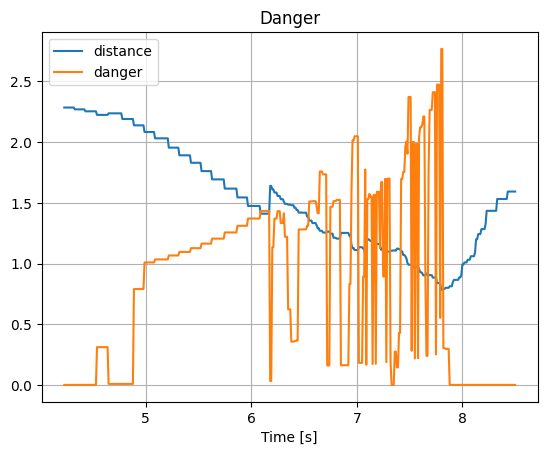

In [576]:
plt.plot(df_100.index, df_100['distance_fusion'], label='distance')
plt.plot(df_100.index, df_100['danger_fusion'], label='danger')
plt.legend()
plt.title('Danger')
plt.ylabel('')
plt.xlabel('Time [s]')
plt.grid()
plt.legend()

In [577]:
df_100['danger_fusion'] = df_100['danger_fusion'].rolling(window=20).mean()

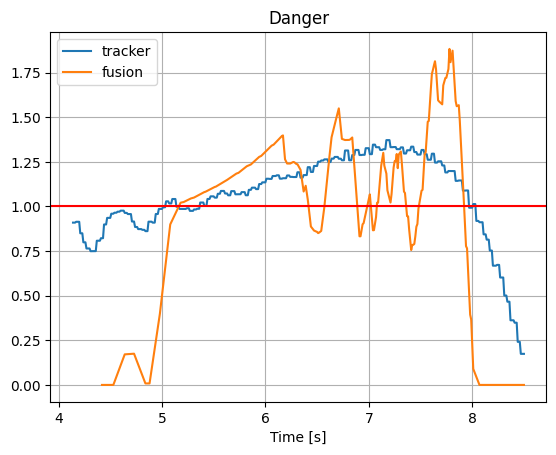

In [578]:
plt.plot(df_100.index, df_100['danger_tracker'], label='tracker')
plt.plot(df_100.index, df_100['danger_fusion'], label='fusion')
plt.axhline(1, color = 'red')
plt.legend()
plt.title('Danger')
plt.ylabel('')
plt.xlabel('Time [s]')
plt.grid()
plt.legend()

In [579]:
first_valid_index = df_100['danger_fusion'].first_valid_index()

In [580]:
y_actual = df_100['danger_tracker'].loc[first_valid_index:]
y_pred = df_100['danger_fusion'].loc[first_valid_index:]
MSE = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(MSE)
rmse

0.4475169230691014

In [581]:
truth = df_100['danger_tracker'].loc[first_valid_index:] < 1
decision = df_100['danger_fusion'].loc[first_valid_index:] < 1 #memory of the semaphore

In [582]:
df_100.index = df_100.index - df_100.index[0]

In [583]:
df_100.to_csv('distance_fusion.csv')

In [584]:
data = [0, 0.4, 0.6, 0.9, 1.1, 1.3, 1.5, 1.2, 1.4, 0.9, 1.4, 1.6, 0.1, 0.1, 0.1, 0.1]
index = list(range(len(data)))
data, index

([0,
  0.4,
  0.6,
  0.9,
  1.1,
  1.3,
  1.5,
  1.2,
  1.4,
  0.9,
  1.4,
  1.6,
  0.1,
  0.1,
  0.1,
  0.1],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

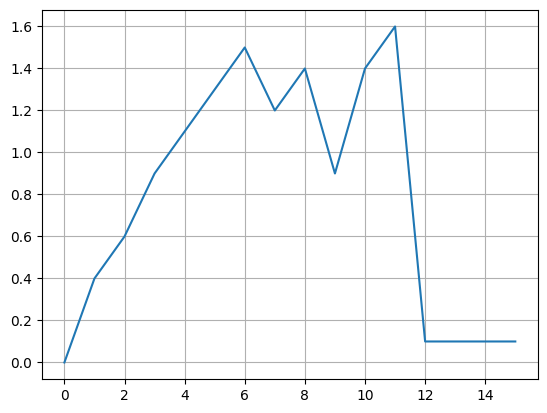

In [585]:
plt.plot(index, data)
plt.grid()

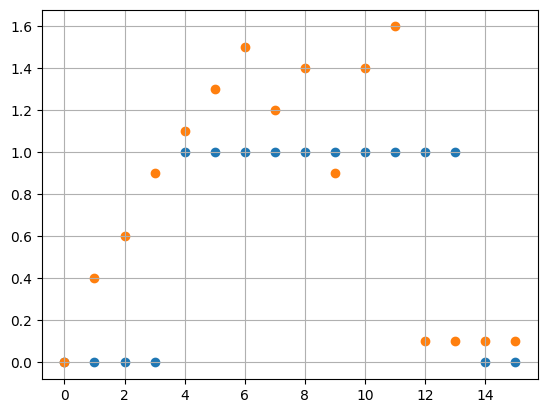

In [586]:
decision = []
memory = []
for i, item in enumerate(data):
    if i<3:
        decision.append(0)
        memory.append(0)
    else:
        numbers = memory[i-3:i]
        if sum(numbers) + item >= 1:
            decision.append(1)
            if item > 1:
                memory.append(1)
            else:
                memory.append(0)
        else:
            decision.append(0)

plt.scatter(index, decision)
plt.scatter(index, data)
plt.grid()


In [587]:
decision = []
memory = []
for i, item in enumerate(df_100['danger_fusion']):
    if item is np.nan:
        item = 1
    if i<10:
        decision.append(0)
        memory.append(0)
    else:
        if sum(memory) + item >= 1:
            decision.append(1)
            if item >= 1:
                memory.append(1)
            else:
                memory.append(0)
            del memory[0]
        else:
            decision.append(0)
            memory.append(0)
            del memory[0]


#decision = []
#for i, item in enumerate(df_100['danger_fusion'].loc[first_valid_index:]):
    #if i < 5:
        #decision.append(0)
    #else:
        #if df_100['danger_fusion'].iloc[i] >1:
            #numbers = decision[i-4:i] + [item]
            #decision.append(np.mean(numbers)<1)
        #else:
            #decision.append(0)

In [588]:
decision = pd.Series(decision, index=df_100.index)

In [589]:
decision

timestamp
0.00    0
0.01    0
0.02    0
0.03    0
0.04    0
       ..
4.75    0
4.76    0
4.77    0
4.78    0
4.79    0
Length: 480, dtype: int64

In [590]:
truth = df_100['danger_tracker']>1

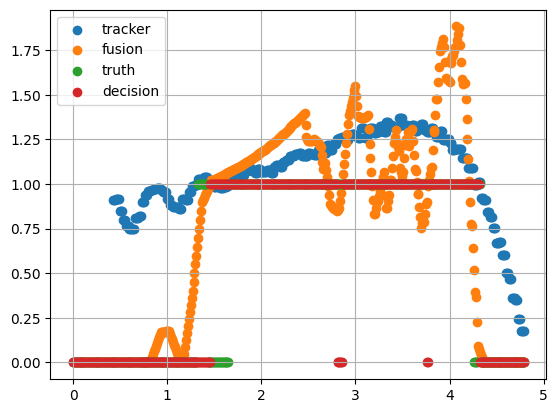

In [591]:
plt.scatter(df_100.index, df_100['danger_tracker'], label='tracker')
plt.scatter(df_100.index, df_100['danger_fusion'], label='fusion')
plt.scatter(df_100.index, truth, label='truth')
plt.scatter(df_100.index, decision, label='decision')
plt.grid()
plt.legend()

In [592]:
#accuracy = accuracy_score(truth, decision)
#precision = precision_score(truth, decision)
#recall = recall_score(truth, decision)

#accuracy, precision, recall

# Weighted Average

In [593]:
df_100['danger_range'] = df_100.apply(danger_function_composed, args=('range',), axis=1)
df_100['danger_wheelchair'] = df_100.apply(danger_function_composed, args=('wheelchair',), axis=1)
df_100['danger_drone'] = df_100.apply(danger_function_composed, args=('drone',), axis=1)

In [594]:
first_valid_index_range = df_100['danger_range'].first_valid_index()
first_valid_index_wheelchair = df_100['danger_wheelchair'].first_valid_index()
first_valid_index_drone = df_100['danger_drone'].first_valid_index()

In [595]:
y_actual = df_100['danger_tracker'].loc[first_valid_index_range:]
y_pred = df_100['danger_range'].loc[first_valid_index_range:]
MSE = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(MSE)
rmse

0.5816935246974213

In [596]:
y_actual = df_100['danger_tracker'].loc[first_valid_index_wheelchair:]
y_pred = df_100['danger_wheelchair'].loc[first_valid_index_wheelchair:]
MSE = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(MSE)
rmse

0.9476541025267474

In [597]:
y_actual = df_100['danger_tracker'].loc[first_valid_index_drone:]
y_pred = df_100['danger_drone'].loc[first_valid_index_drone:]
MSE = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(MSE)
rmse

1.92315937082168

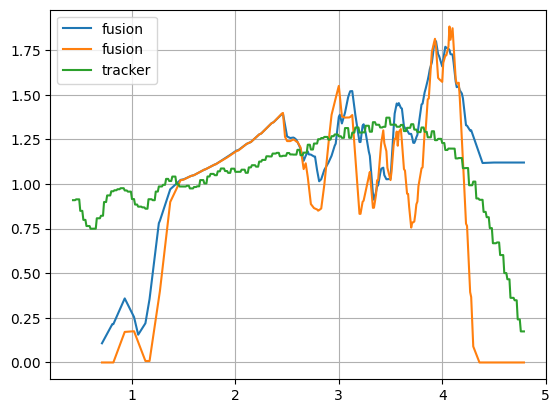

In [598]:
df_100['danger_fusion_avg'] = df_100[['danger_wheelchair','danger_drone','danger_range']].mean(axis=1)
df_100['danger_fusion_avg'] = df_100['danger_fusion_avg'].rolling(window=20).mean()
first_valid_index = df_100['danger_fusion_avg'].first_valid_index()
plt.plot(df_100.index, df_100['danger_fusion_avg'], label='fusion')
plt.plot(df_100.index, df_100['danger_fusion'], label='fusion')
plt.plot(df_100.index,df_100['danger_tracker'], label='tracker')
plt.legend()
plt.grid()

In [599]:
y_actual = df_100['danger_tracker'].loc[first_valid_index:]
y_pred = df_100['danger_fusion_avg'].loc[first_valid_index:]
MSE = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(MSE)
rmse

0.36110151228770804

In [600]:
df_100.columns

Index(['distance_wheelchair', 'speed_wheelchair', 'acceleration_wheelchair',
       'distance_tracker', 'speed_tracker', 'acceleration_tracker',
       'danger_tracker', 'distance_drone', 'speed_drone', 'acceleration_drone',
       'distance_range', 'speed_range', 'acceleration_range',
       'wheelchair_data', 'drone_data', 'tracker_data', 'range_data',
       'distance_fusion', 'speed_fusion', 'acceleration_fusion',
       'danger_fusion', 'danger_range', 'danger_wheelchair', 'danger_drone',
       'danger_fusion_avg'],
      dtype='object')

In [601]:
df_100.to_csv('weighted_fusion.csv')

# Voting

In [602]:
truth = df_100['danger_tracker'].loc[first_valid_index:] < 1
decision_range = df_100['danger_range'].loc[first_valid_index:] < 1
decision_wheelchair = df_100['danger_wheelchair'].loc[first_valid_index:] < 1
decision_drone= df_100['danger_drone'].loc[first_valid_index:] < 1

In [603]:
decision_range.value_counts(), decision_drone.value_counts(), decision_wheelchair.value_counts()

(False    278
 True     131
 Name: danger_range, dtype: int64,
 False    390
 True      19
 Name: danger_drone, dtype: int64,
 False    269
 True     140
 Name: danger_wheelchair, dtype: int64)

In [604]:
def find_majority(values):
    count_true = sum(1 for value in values if value)
    count_false = len(values) - count_true
    if count_true > count_false:
        return True
    elif count_false > count_true:
        return False
    else:
        return False

# Check for majority at each index
majority_values = []
for v1, v2, v3 in zip(decision_range, decision_wheelchair, decision_drone):
    majority_values.append(find_majority([v1, v2, v3]))

majority_values.count(True), majority_values.count(False)

(74, 335)

ValueError: x and y must have same first dimension, but have shapes (409,) and (480,)

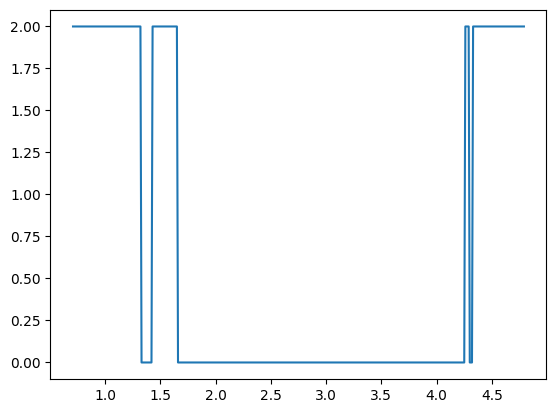

In [605]:
plt.plot(df_100.index[df_100.index.get_loc(first_valid_index):],truth*2, label='truth')
plt.plot(df_100.index[df_100.index.get_loc(first_valid_index):],decision*2, label='decision')
plt.grid()
plt.legend()